<h1> Frequency Analysis </h1>

In this notebook we apply an frequency analysis to USD-UER exchange rate data.

In [1]:
import datetime as dt

import numpy as np
import pandas as pd
from pylab import mpl, plt
import pandas_datareader as pdr

In [2]:
plt.style.use('seaborn')
mpl.rcParams['font.family'] = 'serif'
%matplotlib inline
%matplotlib notebook

<h2> Data Preperation </h2>

These are the parameters for our analysis. We define the start and end time of the data we want to download, and the variable train_test_divide is the datetime that seperates out training data (before this date) and testing data (after this date). The parameters for our OLS model will be the data from the two pervious days, indicated by setting lags to 2.

In [3]:
start = dt.datetime(2010, 1, 4)
train_test_divide = dt.datetime(2014, 6, 29)
end = dt.datetime(2018, 6, 29)
lags = 2

Here we load the data, calculate the returns, and also the direction (whether the returns are positive or negative on a given day).

In [4]:
data = pdr.data.DataReader('DEXUSEU', 'fred', start, end)
data.columns = ['EUR']
data['returns'] = np.log(data / data.shift(1))
data.dropna(inplace=True)
data['direction'] = np.sign(data.returns).astype(int)
print(data.head())

               EUR   returns  direction
DATE                                   
2010-01-05  1.4402 -0.001180         -1
2010-01-06  1.4404  0.000139          1
2010-01-07  1.4314 -0.006268         -1
2010-01-08  1.4357  0.003000          1
2010-01-11  1.4536  0.012391          1


Generate the lag data.

In [5]:
cols = []

for lag in range(1, lags + 1):
    col = f"lag_{lag}"
    data[col] = data["returns"].shift(lag)
    cols.append(col)

data.dropna(inplace=True)
print(data.head())

               EUR   returns  direction     lag_1     lag_2
DATE                                                       
2010-01-07  1.4314 -0.006268         -1  0.000139 -0.001180
2010-01-08  1.4357  0.003000          1 -0.006268  0.000139
2010-01-11  1.4536  0.012391          1  0.003000 -0.006268
2010-01-12  1.4523 -0.000895         -1  0.012391  0.003000
2010-01-13  1.4492 -0.002137         -1 -0.000895  0.012391


Plotting the one and two day lags against each other shows no particular pattern.

<IPython.core.display.Javascript object>


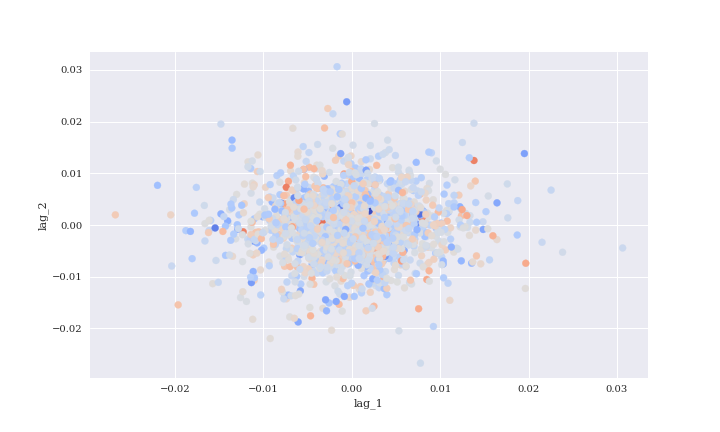

Text(0, 0.5, 'lag_2')

In [6]:
plt.figure(figsize=(10, 6))
plt.scatter(x=data[cols[0]], y=data[cols[1]], c=data['returns'], cmap="coolwarm")
plt.xlabel(cols[0])
plt.ylabel(cols[1])

We now bin the data depending on lag1 and lag2 direction. 

In [7]:
cols_bin = []
for col in cols:
    col_bin = col + "_bin"
    data[col_bin] = np.digitize(data[col], bins=[0])
    cols_bin.append(col_bin)

<h2> Frequency Analysis </h2>

Here we divide our data into training and testing samples.

In [8]:
train = data.iloc[data.index < train_test_divide].copy()
test = data.iloc[data.index >= train_test_divide].copy()

We create four groups based on the four different options for lag_1 and lag_2 direction.

In [9]:
grouped = train.groupby(cols_bin + ['direction'])

From the frequencies, we can see that the only time it is much more likely that the direction will be -1 is if both lag_1 and lag_2 bin are 1. (Though the effect is still very small)

In [10]:
grouped.direction.size().unstack(fill_value=0)

direction             -1   0    1
lag_1_bin lag_2_bin              
0         0          116   0  132
          1          132   1  144
1         0          136   4  137
          1          141   3  135

Test our strategy that we should go short when lag1 and lag2 are positive.

In [11]:
train['pos_freq'] = np.where(train[cols_bin].sum(axis=1)==2, -1, 1)
test['pos_freq'] = np.where(test[cols_bin].sum(axis=1)==2, -1, 1)

In [12]:
train['returns_freq'] = train['pos_freq'] * train['returns']
test['returns_freq'] = test['pos_freq'] * test['returns']

Sum the returns for each model. On both train and test data our frequency strategy marginally outperforms the long strategy, though not by much. I suspect this is not a significant result.

In [13]:
train[['returns', 'returns_freq']].sum().apply(np.exp)

returns         0.980961
returns_freq    1.062359
dtype: float64

In [14]:
test[['returns', 'returns_freq']].sum().apply(np.exp)

returns         0.883380
returns_freq    0.965959
dtype: float64

View the cumulative returns of our model on the train and test set.

<IPython.core.display.Javascript object>


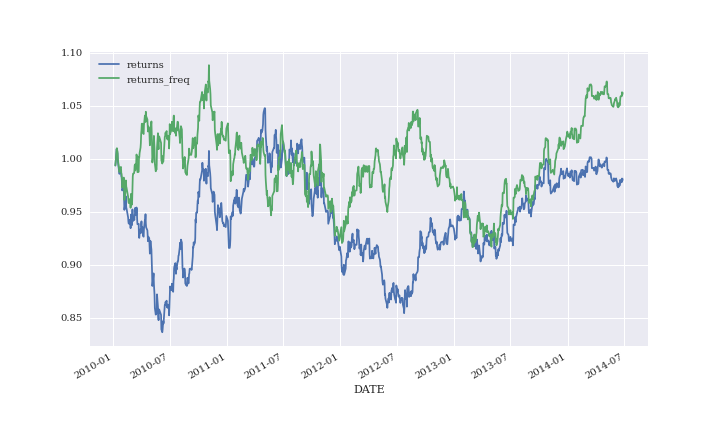

<AxesSubplot:xlabel='DATE'>

In [15]:
train[['returns', 'returns_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6))

<IPython.core.display.Javascript object>


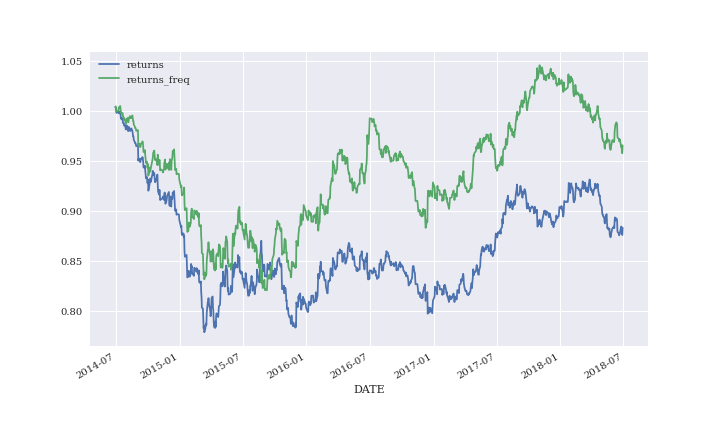

<AxesSubplot:xlabel='DATE'>

In [16]:
test[['returns', 'returns_freq']].cumsum().apply(np.exp).plot(figsize=(10, 6))